# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In this part, we load the training, testing, and validation sets from the give data files.

In [57]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import Image
import pandas as pd
import numpy as np
%matplotlib inline

training_file = './imgs/train.p'
testing_file = './imgs/test.p'
validation_file = './imgs/valid.p'
def open_file(input_file):
    with open(input_file, mode='rb') as f:
        output_file = pickle.load(f)
    X_data, y_data = output_file['features'], output_file['labels']
    return X_data, y_data

X_train, y_train = open_file(training_file)
X_test, y_test = open_file(testing_file)
X_validation, y_validation = open_file(validation_file)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

There are 34799, 12630 and 4410 samples for the training, test, and validation sets.
Each image has the size of (32,32,3), and there are 43 unique classes.

In [58]:
### Replace each question mark with the appropriate value. 


# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

n_validation = len(X_validation)

# shape of an traffic sign image
image_shape = X_train.shape

# unique classes/labels there in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

We visualize the German Traffic Signs Dataset in this section. The distributions of the training, testing and validation sets look similar to each other. They are not uniformly distributed, and the number of samples for some labels (such as 0, 19) is much smaller than the others. The following parts show 15 images with their labels.

5


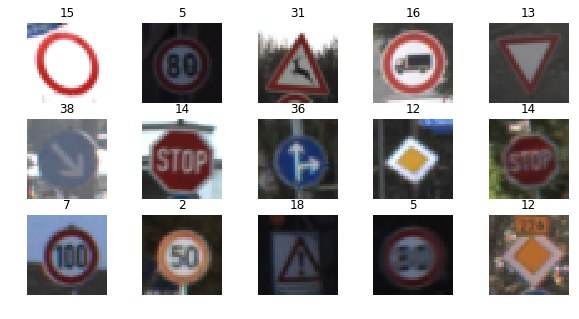

In [59]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
import random
# show image of 10 random data points
num_img_show = 15
num_row = 3
num_col = int(num_img_show / num_row)
print (num_col)
fig, axs = plt.subplots(num_row, num_col, figsize=(10, 5))

#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(num_img_show):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(y_train[index])
    


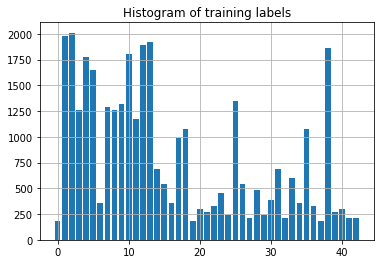

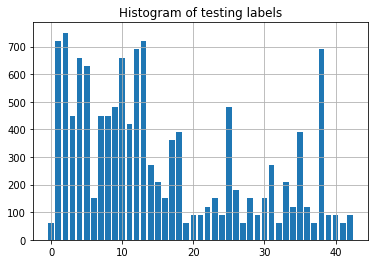

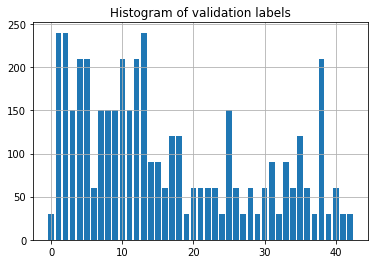

In [49]:
# histogram of label frequency
def display_hist(y_data, hist_title):
    unique_data, counts_data = np.unique(y_data, return_counts=True)
    plt.bar(unique_data, counts_data)
    plt.grid()
    plt.title(hist_title)
    plt.show()
display_hist(y_train, 'Histogram of training labels')
display_hist(y_test, 'Histogram of testing labels')
display_hist(y_validation, 'Histogram of validation labels')

----

## Step 2: Design and Test a Model Architecture

In this part, we design and implement a deep learning model that learns to recognize traffic signs. 
Our model is based on LeNet-5. In the pre-processing stage, we combine channel wise compression and normalization. We also do data augmentation to improve the prediction results.


### Pre-process the Data Set (normalization, grayscale, etc.)

We firstly compute the mean slice from RGB channels. For normalization,  we use `(pixel - 128)/ 128` to approximately normalize the data. 

-0.354081335648


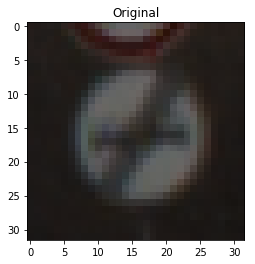

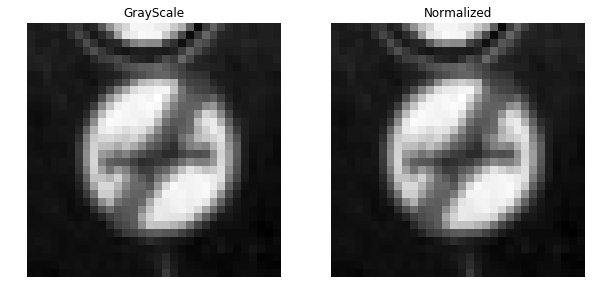

In [60]:
### Preprocess the data here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from math import ceil
from sklearn.utils import shuffle

def reduce_channel(x):
    out = np.sum(x / 3, axis = 3, keepdims = True) 
    return out

def f_normalize(x):
    out =  (x - 128) / 128
    return out

X_train0 = X_train
X_train_gray = reduce_channel(X_train)
X_test_gray = reduce_channel(X_test)
X_validation_gray = reduce_channel(X_validation)


X_train = f_normalize(X_train_gray)
X_train1 = X_train
X_validation = f_normalize(X_validation_gray)
X_test = f_normalize(X_test_gray)
print (np.mean(X_train))
# print (np.mean(X_test))
# X_train.shape

idx_disp = 9
plt.imshow(X_train0[idx_disp])
plt.title("Original")

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

for i in range(2):
    if i == 0:
        axs[i].imshow(X_train_gray[idx_disp].squeeze(), cmap = 'gray')
        axs[i].set_title('GrayScale')
    else:
        axs[i].imshow(X_train1[idx_disp].squeeze(), cmap = 'gray')
        axs[i].set_title("Normalized")
    axs[i].axis('off')
    


### Data augmentation

We mainly use translation, rotation and scaling for data augmentation on the labels with small number of samples (such as 1500).  For specific images after those transformations, one can open another file 'augmentation_display' in the folder. It is shown that the new training set after augmentation has better distribution.

In [8]:
import collections, cv2

train_dict_counts = collections.Counter(y_train)
X_train_aug, y_train_aug = [], []
X_train_now, y_train_now = [], []
for i in range(n_train):
    if(train_dict_counts[y_train[i]] < 1500):
        for j in range(3):
            # translation
            dx, dy = np.random.randint(-2, 2, 2)
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            dst = cv2.warpAffine(X_train[i], M, (X_train[i].shape[0], X_train[i].shape[1]))
            dst = dst[:,:,None]
            X_train_aug.append(dst)
            y_train_aug.append(y_train[i])
            
            # rotation
            tilt = np.random.randint(-10, 10)
            M = cv2.getRotationMatrix2D((X_train[i].shape[0]/2, X_train[i].shape[1]/2), tilt, 1)
            dst2 = cv2.warpAffine(X_train[i], M, (X_train[i].shape[0], X_train[i].shape[1]))
            dst2 = dst2[:,:,None]
            X_train_aug.append(dst2)
            y_train_aug.append(y_train[i])

            # scaling
            rows = 32
            cols = 32
            # transform limits
            px = np.random.randint(-3, 3)
            # ending locations
            pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])
            # starting locations (4 corners)
            pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst3 = cv2.warpPerspective(X_train[i],M,(rows,cols))
            dst3 = dst3[:,:,None]
            X_train_aug.append(dst3)
            y_train_aug.append(y_train[i])
            train_dict_counts[y_train[i]] += 3
            
            
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
X_train_now = np.array(X_train_now)
y_train_now = np.array(y_train_now)
X_train_now = np.concatenate((X_train, X_train_aug), axis=0)
y_train_now = np.concatenate((y_train, y_train_aug), axis=0)

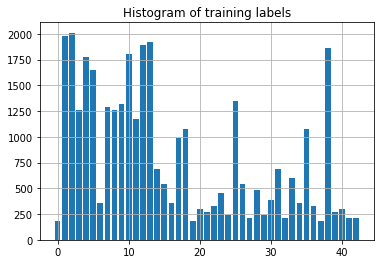

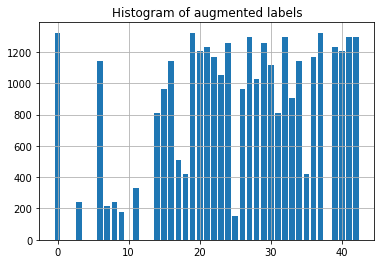

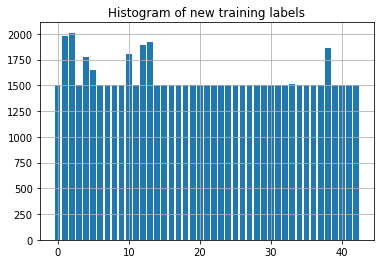

Number of samples of augmented training set = 67496


In [44]:

display_hist(y_train, 'Histogram of training labels')
display_hist(y_train_aug, 'Histogram of augmented labels')
display_hist(y_train_now, 'Histogram of new training labels')
print("Number of samples of augmented training set =", len(y_train_now))

### Model Architecture
We modify LeNet-5 a little bit by using different fc layers. The first conv layer's output is also changed from 6 to 8.

In [9]:
### Define your architecture here.
def conv2d(x, W, b, strides):
    # conv + bias + relu
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    #print(x.shape)
    return tf.nn.relu(x)

from tensorflow.contrib.layers import flatten
image_depth_channels = 1

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 14x14x8.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 8), mean = mu, stddev = sigma))
    b1 = tf.Variable(tf.zeros(8))
    x = conv2d(x, W1, b1, 1)
    print("layer 1 shape:",x.get_shape())
    # TODO: Pooling. Input = 28x28x8. Output = 14x14x8.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 16), mean = mu, stddev = sigma))
    b2 = tf.Variable(tf.zeros(16))
    x = conv2d(x, W2, b2, 1)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 128.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 128), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(128))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 128. Output = 64.
    W4 = tf.Variable(tf.truncated_normal(shape=(128, 64), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(64)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 64. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(64, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits


### Train, Validate and Test the Model

In this section, we train the model with the augmented training data set (67496 samples).
After 15 epochs, the validation accuracy is 0.946 and the test set accuracy is 0.916, (If run multiple times, the test set accuracy can be 0.937 or higher)

In [11]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

rate = 0.001
EPOCHS = 15
BATCH_SIZE = 100


tf.reset_default_graph() 
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()



def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_now, y_train_now)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        #X_validation, y_validation = X_train, y_train     
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet2')
    print("Model saved")
    


layer 1 shape: (?, 28, 28, 8)
Training...

EPOCH 1 ...
Validation Accuracy = 0.485

EPOCH 2 ...
Validation Accuracy = 0.738

EPOCH 3 ...
Validation Accuracy = 0.815

EPOCH 4 ...
Validation Accuracy = 0.843

EPOCH 5 ...
Validation Accuracy = 0.879

EPOCH 6 ...
Validation Accuracy = 0.893

EPOCH 7 ...
Validation Accuracy = 0.898

EPOCH 8 ...
Validation Accuracy = 0.898

EPOCH 9 ...
Validation Accuracy = 0.911

EPOCH 10 ...
Validation Accuracy = 0.908

EPOCH 11 ...
Validation Accuracy = 0.928

EPOCH 12 ...
Validation Accuracy = 0.934

EPOCH 13 ...
Validation Accuracy = 0.935

EPOCH 14 ...
Validation Accuracy = 0.940

EPOCH 15 ...
Validation Accuracy = 0.949

Model saved


In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet2.meta')
    saver2.restore(sess, "./lenet2")
    
    train_accuracy = evaluate(X_train, y_train)
    print("Train Set Accuracy = {:.3f}".format(train_accuracy))
    
    validation_accuracy = evaluate(X_validation, y_validation)
    print("Validation Set Accuracy = {:.3f}".format(validation_accuracy))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet2
Train Set Accuracy = 0.984
Validation Set Accuracy = 0.949
Test Set Accuracy = 0.916


---

## Step 3: Test a Model on New Images

We download 6 pictures of German traffic signs from the web and use our model to predict the traffic sign type.

### Load and Output the Images
We firstly show the labels and the images from the web.

In [79]:
name_values = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

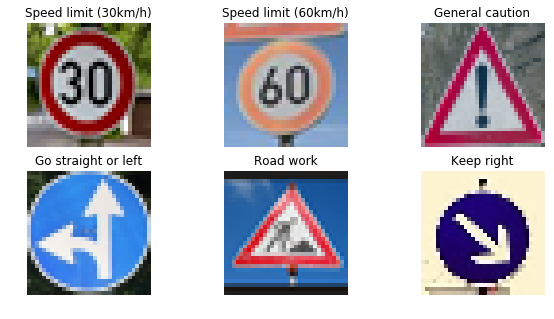

In [80]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
my_imgs = sorted(glob.glob('./mysigns/*.png'))
my_labels = np.array([1,3,18,37,25,38])

figures = {}
labels = {}
my_signs = []
index = 0
for my_img in my_imgs:
    img = cv2.cvtColor(cv2.imread(my_img), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')
    index += 1


fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(6):
    
    image = figures[i]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(labels[i])
    

### Predict the Sign Type for Each Image

In [81]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

my_signs = np.array(my_signs)
my_signs_gray = f_normalize(reduce_channel(my_signs))

def predict_data(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred_sign

signs_prediction = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet2")
    signs_prediction = predict_data(my_signs_gray, sess)
    print (signs_prediction)



INFO:tensorflow:Restoring parameters from ./lenet2
[ 0  3 18 37 25 38]


### Analyze Performance
Our model predicts the 6 images with accuracy of 0.833.

0.8333333333333334


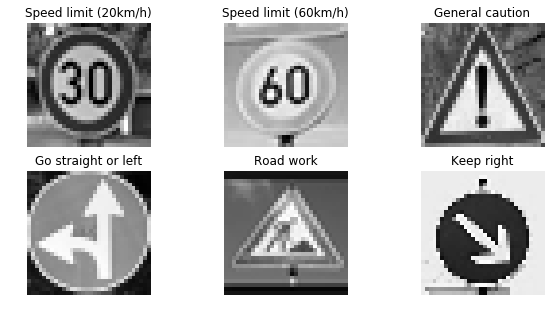

In [82]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

prediction_accuracy = 0
num_samples = 6
for i in range(num_samples):
    if signs_prediction[i] == my_labels[i]:
        prediction_accuracy += 1

prediction_accuracy /= num_samples
print (prediction_accuracy)


figures = {}
labels = {}
my_signs = []

for i in range(6):
    labels[i] = name_values[signs_prediction[i]][1].decode('ascii')

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(6):
      
    image = my_signs_gray[i].squeeze()
    axs[i].imshow(image, cmap = 'gray')
    axs[i].axis('off')
    axs[i].set_title(labels[i])

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, we print out the model's softmax probabilities to show the **certainty** of the model's predictions.

In [83]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

k = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k = k)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     my_saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet2")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_signs_gray, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_signs_gray, keep_prob: 1.0})
    print(my_top_k)


INFO:tensorflow:Restoring parameters from ./lenet2
TopKV2(values=array([[  9.80552256e-01,   1.94476601e-02,   8.44080787e-08,
          1.24104249e-09,   5.37597952e-11],
       [  9.68103051e-01,   1.58350542e-02,   1.32424226e-02,
          9.70341265e-04,   8.39229499e-04],
       [  9.99981284e-01,   1.58024850e-05,   2.85552164e-06,
          5.55422063e-11,   1.35281340e-13],
       [  9.99989271e-01,   6.09276958e-06,   4.18912077e-06,
          2.94669633e-07,   1.09692955e-07],
       [  6.03022337e-01,   7.70330653e-02,   6.60675243e-02,
          5.55642508e-02,   4.67177033e-02],
       [  1.00000000e+00,   1.39134608e-17,   4.44992771e-18,
          1.49465501e-19,   1.42893738e-20]], dtype=float32), indices=array([[ 0,  1,  4,  2,  3],
       [ 3,  0,  5,  1, 34],
       [18, 27, 26, 24, 11],
       [37,  1, 40, 33, 39],
       [25, 21, 30, 29, 23],
       [38, 13, 12, 20, 34]]))
